# Analisando os acidentes nas rodovias federais do Brasil

| Seção | Parte                                        |  
| :-      |:-                                          |  
| 0       | [Introdução](#intro)                       |           
|  1      | [Coleta de dados](#coleta)                 |
|  2      | [Pré-processamento](#prep)                 | 
|  3      | [Visualizações](#viz)                      |    
|  4      | [Estatísticas](#estatisticas)              |      
|  5      | [Normalização](#norm)      |
   

<a id="intro"/>

## 0. Introdução

Este notebook apresenta uma análise de dados dos acidentes de trânsito ocorridos em rodovias federais no Brasil. O dataset é fornecido pela Polícia Rodoviária Federal (PRF) e nos dá as ocorrências entre o período de 2007 a 2021. Para esta análise foi utilizado apenas o período de Janeiro de 2017 à Junho de 2021, pois algumas colunas só foram introduzidas a partir de 2017.

O dataset pode ser obtido  no [Kaggle](https://www.kaggle.com/mcamera/brazil-highway-traffic-accidents). 

Nesta análise nos propomos a responder as seguintes perguntas:

- Qual período do dia acontecem mais acidentes?
- O número de acidentes no país está em alta?
- Quais dias da semana mais ocorrem acidentes?
- Qual o estado com maior ocorrência de acidentes?
- Qual a gravidade dos acidentes em cada estado?
- Qual o número de ocorrências anuais para cada estado?
- Quais as correlações entre as features númericas dos acidentes no Brasil?

Autores: Aian Shay e Tassiane Barros.

<a id="coleta"/>

## 1. Coleta de dados

##### Importação de bibliotecas

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import datetime

!pip3 install holidays
import holidays

!pip3 install scikit-learn
from sklearn.preprocessing import MinMaxScaler

##### Carregando os dados

In [4]:
files = glob.glob("por_ocorrencia/ocorrencias_final/*.csv")
dfs = [pd.read_csv(f, sep=";", encoding = "ISO-8859-1") for f in files]

ocorrencias = pd.concat(dfs, ignore_index=True)

##### Visualização de parte dos dados do dataset 

In [5]:
ocorrencias.head(100)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,8.0,2017-01-01,domingo,00:00:00,PR,376.0,112,PARANAVAI,Fenômenos da Natureza,Queda de ocupante de veículo,...,1,0,0,1,1,"-23,09880731","-52,38789369",SR-PR,DEL7/7,UOP05/PR
1,9.0,2017-01-01,domingo,00:01:00,SC,101.0,234,PALHOCA,Falta de Atenção à Condução,Colisão com objeto estático,...,0,1,0,0,1,"-27,8101","-48,6357",SR-SC,DEL8/1,UOP02/SC
2,11.0,2017-01-01,domingo,00:00:00,PR,153.0,"56,9",SANTO ANTONIO DA PLATINA,Animais na Pista,Capotamento,...,0,0,0,2,1,"-23,36951985","309,93513107",SR-PR,DEL7/7,UOP07/PR
3,12.0,2017-01-01,domingo,00:00:00,GO,153.0,435,ANAPOLIS,Avarias e/ou desgaste excessivo no pneu,Tombamento,...,1,0,0,1,1,"-16,27473677","-48,96908998",SR-GO,DEL1/2,UOP01/GO
4,13.0,2017-01-01,domingo,00:00:00,SC,280.0,"77,3",CORUPA,Ingestão de Álcool,Saída de leito carroçável,...,0,0,0,1,1,"-26,44675249","-49,20166969",SR-SC,DEL8/6,UOP03/SC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,128.0,2017-01-01,domingo,11:50:00,SP,101.0,41,UBATUBA,Não guardar distância de segurança,Colisão frontal,...,0,6,0,1,2,"-23,3841626","-44,9720059",SR-SP,DEL6/7,UOP01/SP
96,129.0,2017-01-01,domingo,10:30:00,MT,364.0,469,VARZEA GRANDE,Defeito Mecânico no Veículo,Tombamento,...,0,0,0,3,1,"-15,35686639","-56,41299248",SR-MT,DEL2/4,UOP02/MT
97,130.0,2017-01-01,domingo,10:30:00,PA,222.0,"243,4",MARABA,Falta de Atenção à Condução,Tombamento,...,0,0,0,1,1,"-5,3257047","-49,08627033",SR-PA,DEL19/3,UOP01/PA
98,131.0,2017-01-01,domingo,12:00:00,PR,467.0,92,CASCAVEL,Avarias e/ou desgaste excessivo no pneu,Saída de leito carroçável,...,0,2,0,1,1,"-24,8537579","-53,5995431",SR-PR,DEL7/4,UOP06/PR


In [9]:
lines, columns = ocorrencias.shape
print(f'O dataset possui {lines} ocorrências e {columns} colunas.')

O dataset possui 320753 ocorrências e 30 colunas.


<a id="prep"/>

## 2. Pré-processamento

In [10]:
ocorrencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320753 entries, 0 to 320752
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      320753 non-null  float64
 1   data_inversa            320753 non-null  object 
 2   dia_semana              320753 non-null  object 
 3   horario                 320753 non-null  object 
 4   uf                      320753 non-null  object 
 5   br                      320156 non-null  float64
 6   km                      320156 non-null  object 
 7   municipio               320753 non-null  object 
 8   causa_acidente          320753 non-null  object 
 9   tipo_acidente           320753 non-null  object 
 10  classificacao_acidente  320753 non-null  object 
 11  fase_dia                320753 non-null  object 
 12  sentido_via             320753 non-null  object 
 13  condicao_metereologica  320753 non-null  object 
 14  tipo_pista          

In [ ]:
ocorrencias['data_inversa'].value_counts()

2017-12-23    449
2017-02-25    409
2017-12-22    397
2017-05-19    390
2017-09-30    366
             ... 
2018-05-26     83
2020-03-26     77
2018-05-29     75
2020-03-25     72
2020-03-23     70
Name: data_inversa, Length: 1642, dtype: int64

Observamos que as colunas `br` e `km` estão com o formato inadequado, deveriam ser do tipo `int` e `float`, respectivamente. Além disso, há alguns valores nulos nessas colunas também. E a coluna da data está invertida, iremos transformá-la para o formato brasileiro.

In [10]:
ocorrencias[ocorrencias['km'].isnull()]

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
1171,184100.0,2019-01-08,terça-feira,21:25:00,RS,NaN,NaN,SAO BORJA,Pista Escorregadia,Colisão traseira,...,0,2,1,0,2,"-28,66158775","-55,99882414",SR-RS,DEL9/12,UOP01/RS
1629,184669.0,2019-01-11,sexta-feira,20:36:00,CE,NaN,NaN,ITAITINGA,Falta de Atenção à Condução,Colisão com objeto estático,...,0,4,0,0,2,"-3,9240005","-38,5144729",SR-CE,DEL16/1,UOP02/CE
1683,184736.0,2019-01-12,sábado,03:00:00,PR,NaN,NaN,FAZENDA RIO GRANDE,Falta de Atenção à Condução,Capotamento,...,0,1,0,0,1,"-25,71329112","-49,31824197",SR-PR,DEL7/1,UOP03/PR
2343,185538.0,2019-01-16,quarta-feira,08:40:00,GO,NaN,NaN,CATALAO,Falta de Atenção à Condução,Colisão transversal,...,0,1,0,1,2,"-18,10702393","-47,8894043",SR-GO,DEL1/6,UOP01/GO
2712,186005.0,2019-01-18,sexta-feira,16:45:00,CE,NaN,NaN,FORTALEZA,Defeito Mecânico no Veículo,Colisão com objeto estático,...,0,3,2,0,3,"-3,74484893","-38,58854413",SR-CE,CE,SRPRF/CE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319309,366313.0,2021-06-17,quinta-feira,21:00:00,SP,NaN,NaN,SAO LOURENCO DA SERRA,Frear bruscamente,Colisão traseira,...,0,2,0,0,2,"-23,86213995","-46,94718508",SR-SP,UOP01,DEL04
319379,366389.0,2021-06-25,sexta-feira,14:00:00,RJ,NaN,NaN,TANGUA,Reação tardia ou ineficiente do condutor,Colisão transversal,...,1,1,0,1,2,"-22,735125","-42,719902",SR-RJ,UOP03,DEL02
319717,366765.0,2021-06-27,domingo,08:09:00,SP,NaN,NaN,EMBU DAS ARTES,Reação tardia ou ineficiente do condutor,Colisão com objeto,...,0,2,0,0,1,"-23,65651401","-46,85200095",SR-SP,DEL04,SP
319891,366957.0,2021-06-28,segunda-feira,06:00:00,RJ,NaN,NaN,ANGRA DOS REIS,Ingestão de álcool e/ou substâncias psicoativa...,Saída de leito carroçável,...,0,1,0,4,1,"-23,02147898","-44,52344494",SR-RJ,UOP02,DEL03


Nas duas células acima, vimos que as colunas `km` e `br` possuem 597 valores NaN, como elas são apenas 0.18% do dataset, decidimos descartá-las.

In [16]:
ocorrencias.dropna(subset=['km', 'br'], inplace=True)
ocorrencias.isnull().sum()

id                            0
data_inversa                  0
dia_semana                    0
horario                       0
uf                            0
br                            0
km                            0
municipio                     0
causa_acidente                0
tipo_acidente                 0
classificacao_acidente        0
fase_dia                      0
sentido_via                   0
condicao_metereologica        0
tipo_pista                    0
tracado_via                   0
uso_solo                      0
pessoas                       0
mortos                        0
feridos_leves                 0
feridos_graves                0
ilesos                        0
ignorados                     0
feridos                       0
veiculos                      0
latitude                      0
longitude                     0
regional                      0
delegacia                     0
uop                       11047
dtype: int64

Agora podemos ver que não existem mais valores nulos nas colunas `km` e `br`.

Para transformarmos a coluna `km` para float, primeiro trocamos a vírgula pelo ponto, para que o Python reconheca como float.

In [17]:
def replace_comma(value):
    return value.replace(',', '.')

ocorrencias['km'] = ocorrencias['km'].apply(replace_comma)
ocorrencias['km'] = ocorrencias['km'].astype(float)
ocorrencias['br'] = ocorrencias['br'].astype(int)

ocorrencias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320156 entries, 0 to 320752
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      320156 non-null  float64
 1   data_inversa            320156 non-null  object 
 2   dia_semana              320156 non-null  object 
 3   horario                 320156 non-null  object 
 4   uf                      320156 non-null  object 
 5   br                      320156 non-null  int64  
 6   km                      320156 non-null  float64
 7   municipio               320156 non-null  object 
 8   causa_acidente          320156 non-null  object 
 9   tipo_acidente           320156 non-null  object 
 10  classificacao_acidente  320156 non-null  object 
 11  fase_dia                320156 non-null  object 
 12  sentido_via             320156 non-null  object 
 13  condicao_metereologica  320156 non-null  object 
 14  tipo_pista          

Nesta parte trasformamos a data inversa para o formato brasileiro.

In [17]:
def convert_date(date):
    return date.strftime('%d/%m/%Y')

ocorrencias['data'] = pd.to_datetime(ocorrencias['data_inversa']).apply(convert_date)
ocorrencias[['data_inversa', 'data']]

,data_inversa,data
0,2017-01-01,01/01/2017
1,2017-01-01,01/01/2017
2,2017-01-01,01/01/2017
3,2017-01-01,01/01/2017
4,2017-01-01,01/01/2017
...,...,...
320748,2018-12-24,24/12/2018
320749,2018-12-12,12/12/2018
320750,2018-11-15,15/11/2018
320751,2018-11-23,23/11/2018


Decidimos criar uma coluna `ano`, que torna possível realizarmos a contagem anual e plotar um gráfico de série histórica.

In [18]:
ocorrencias['ano'] = [datetime.strptime(data, '%d/%m/%Y').year for data in ocorrencias['data']]
ocorrencias[['data', 'ano','horario']]

,data,ano,horario
0,01/01/2017,2017,00:00:00
1,01/01/2017,2017,00:01:00
2,01/01/2017,2017,00:00:00
3,01/01/2017,2017,00:00:00
4,01/01/2017,2017,00:00:00
...,...,...,...
320748,24/12/2018,2018,09:15:00
320749,12/12/2018,2018,07:00:00
320750,15/11/2018,2018,10:48:00
320751,23/11/2018,2018,19:30:00


Decidimos também criar a coluna `periodo` para indicar o turno do dia daquela ocorrência, por meio da **discretização** dos horários em `manhã`, `tarde`, `noite` e `madrugada` . Assim podemos descobrir quais os períodos que ocorrem mais e menos acidentes.

In [12]:
def periodo(linha):
  horario = linha['horario']
  if '06:00:00' <= horario <= '11:59:00': return 'Manha'
  elif '12:00:00' <= horario <= '17:59:00': return 'Tarde'
  elif '18:00:00' <= horario <= '23:59:00': return 'Noite'
  elif '00:00:00' <= horario <= '05:59:00': return 'Madrugada'
  else: return ''

ocorrencias['periodo'] = ocorrencias.apply(periodo, axis=1)
ocorrencias[['horario','periodo']]

,horario,periodo
0,00:00:00,Madrugada
1,00:01:00,Madrugada
2,00:00:00,Madrugada
3,00:00:00,Madrugada
4,00:00:00,Madrugada
...,...,...
320748,09:15:00,Manha
320749,07:00:00,Manha
320750,10:48:00,Manha
320751,19:30:00,Noite


Checando se todos os UF estão formatados corretamente.

In [22]:
ocorrencias['uf'].unique()

array(['SP', 'PR', 'SC', 'CE', 'MG', 'MS', 'GO', 'RS', 'RJ', 'PB', 'RN',
       'PE', 'SE', 'DF', 'TO', 'MT', 'ES', 'RO', 'PA', 'AL', 'AM', 'MA',
       'BA', 'PI', 'AP', 'RR', 'AC'], dtype=object)

Agora os dados estão prontos para serem utilizados para plotarmos os gráficos.

<a id="viz"/>

## 3. Visualizações

#### 3.1 Qual período do dia acontecem mais acidentes?

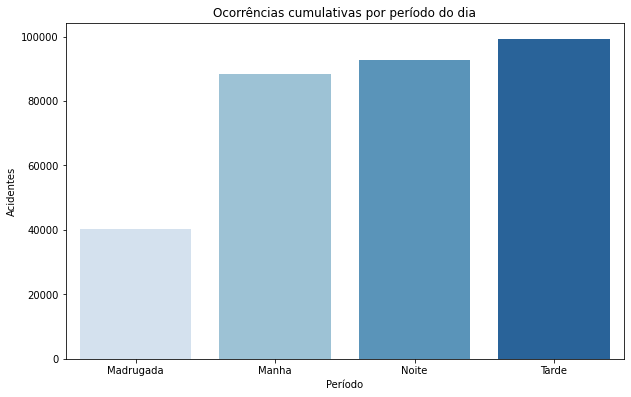

In [14]:
periodo_count = ocorrencias['periodo'].value_counts()
periodo_labels = periodo_count.keys()
periodo_values = periodo_count.values

plt.figure(figsize=(10, 10/1.6180339))
sns.barplot(x=periodo_labels[::-1], y=periodo_values[::-1], palette='Blues')
plt.title('Ocorrências cumulativas por período do dia')
plt.xlabel('Período')
plt.ylabel('Acidentes');

Nota-se que o período que ocorre mais acidentes é a tarde, com manhã e noite com números similares e a madrugada ficou com o menor número de ocorrências, o que faz sentido, visto que a maioria das pessoas está em casa.

#### 3.2 O número de acidentes no país está em alta? 

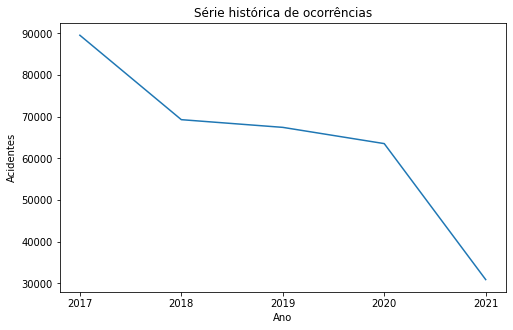

In [20]:
anos_count = ocorrencias['ano'].value_counts()
anos_y = anos_count.values

plt.figure(figsize=(8, 8/1.6180339))
sns.lineplot(x=['2017', '2018', '2019', '2020', '2021'], y=anos_y)
plt.title('Série histórica de ocorrências')
plt.xlabel('Ano')
plt.ylabel('Acidentes');

Nota-se que os números apresentam uma têndencia de queda desde 2017, com uma redução significativa de 2017 para 2018, e uma leve queda de 2018 até 2020. É importante ressaltar que os números de 2021 estão incompletos, pois o ano ainda não acabou.

#### 3.3 Quais dias da semana mais ocorrem acidentes?

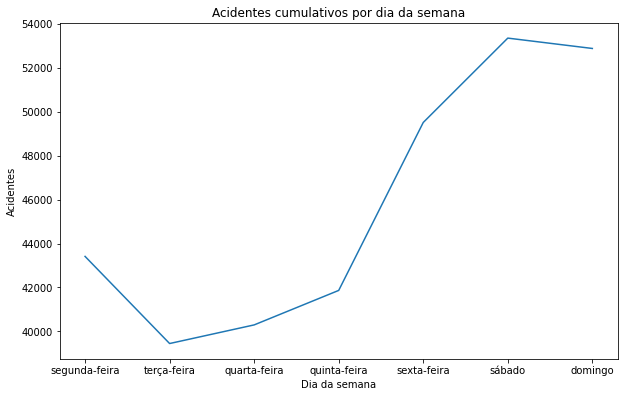

In [21]:
dia_semana_count = ocorrencias['dia_semana'].value_counts()
dia_semana_x = ['segunda-feira', 'terça-feira', 'quarta-feira', 
                'quinta-feira', 'sexta-feira','sábado', 'domingo']

#ordenando o dict de segunda a domingo
count_semanal = {}
for dia in dia_semana_x:
    count_semanal[dia] = dia_semana_count[dia]

plt.figure(figsize=(10, 10/1.6180339))
sns.lineplot(x=list(count_semanal.keys()), y=list(count_semanal.values()), palette='Blues')
plt.title('Acidentes cumulativos por dia da semana')
plt.xlabel('Dia da semana')
plt.ylabel('Acidentes');

Nota-se que há um aumento expressivo de acidentes durante o fim de semana. Imaginamos que isso ocorra pois muitas pessoas pegam a estrada para irem visitar outros lugares (praias, balneários etc.) em seus dias de descanso.

#### 3.4 Qual o estado com maior ocorrência de acidentes?

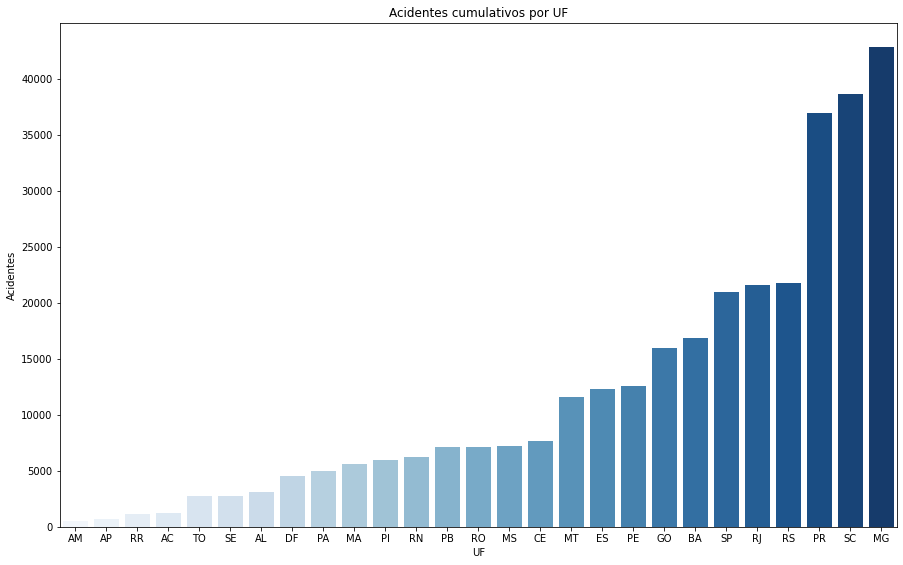

In [7]:
uf_count = ocorrencias['uf'].value_counts()
uf_labels = uf_count.keys()
uf_value = uf_count.values

plt.figure(figsize=(15,15/1.6190339))
sns.barplot(x=uf_labels[::-1], y=uf_value[::-1], palette='Blues')
plt.title('Acidentes cumulativos por UF')
plt.xlabel('UF')
plt.ylabel('Acidentes');

Nota-se que os estados com mais ocorrências, com grande margem, são Minas Gerais, Santa Catarina e Paraná. Vê-se também que, os estados do Norte, apesar de terem maior parte do território brasileiro, não registram muitas ocorrências, ficando nas últimas posições. Acreditamos que isso pode ter haver com o fato de serem regiões menos desenvolvidas, menos conectadas e com menor densidade populacional.

#### 3.5 Qual a gravidade dos acidentes em cada estado?

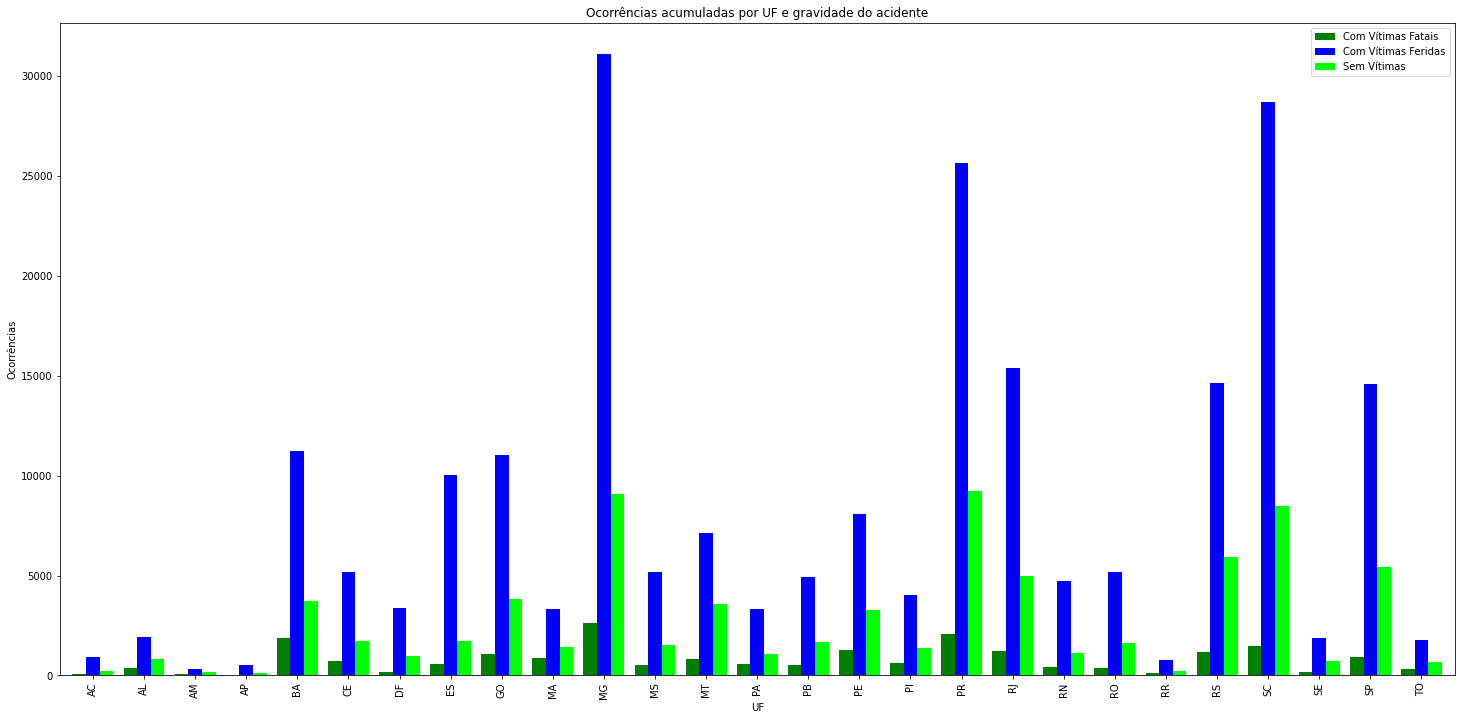

In [29]:
table = pd.crosstab(ocorrencias['uf'], ocorrencias['classificacao_acidente'])
table.plot(kind='bar', width=.8, color=['green', 'blue', 'lime'], 
           title='Ocorrências acumuladas por UF e gravidade do acidente', figsize=(25, 12), fontsize=10)
plt.legend(title='')
plt.xlabel('UF')
plt.ylabel('Ocorrências');

O gráfico mostra a quantidade de acidentes sem vítima, com vítimas feridas e com vítimas fatais em cada estado brasileiro. Os estados que mais ocorreram acidentes foram Minas Gerais, Santa Catarina e Paraná. 

Na maioria dos acidentes houveram vítimas feridas, mas que não tem muitas vítimas fatais.

**OBS**: Antes da plotagem desse gráfico tinhamos a hipótese de que São Paulo seria o estado que teria mais acidentes, por ser mais populoso e consequentemente possuir mais veículos, mas não é o que o gráfico indica.

#### 3.6 Qual o número de ocorrências anuais para cada estado?

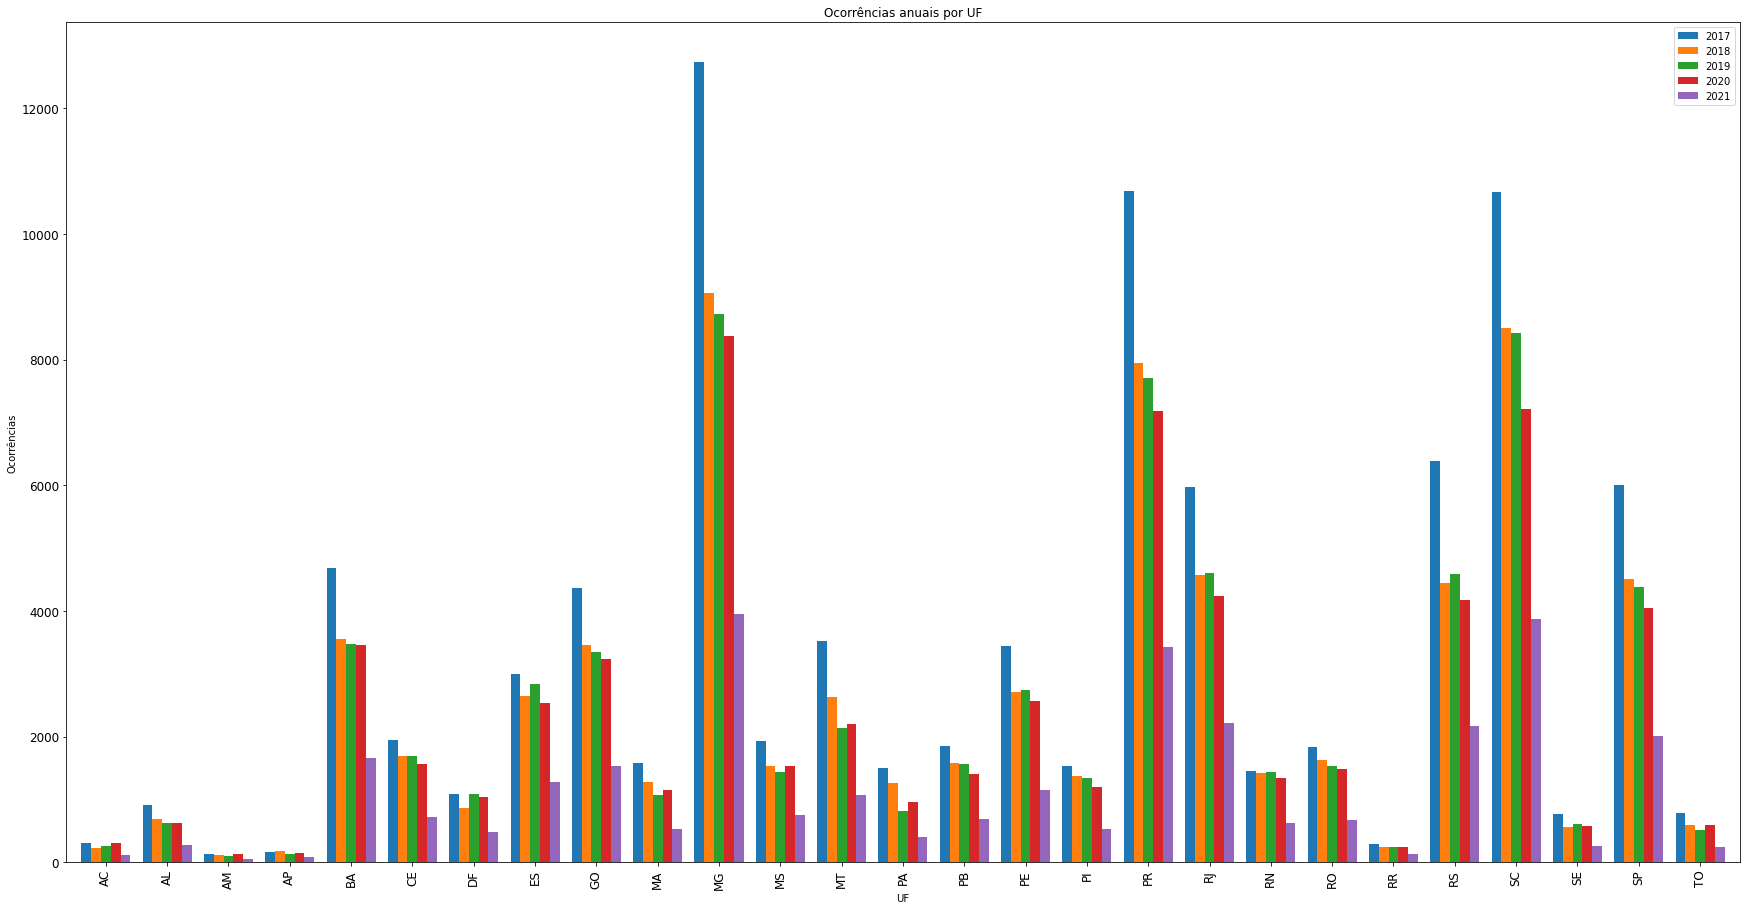

In [48]:
table = pd.crosstab(ocorrencias['uf'], ocorrencias['ano'])
table.plot(kind='bar', width=.8, title='Ocorrências anuais por UF', 
           figsize=(30, 25/1.6180339), fontsize=12)
plt.legend(title='')
plt.xlabel('UF')
plt.ylabel('Ocorrências');

- No ano de 2017 os estados que mais ocorreram acidentes foram Minas Gerais, Paraná e Santa Catarina.
- No ano de 2018 os estados que mais ocorreram acidentes foram Minas Gerais, Santa Catarina e Paraná.
- No ano de 2019 os estados que mais ocorreram acidentes foram Minas Gerais, Santa Catarina e Paraná.
- No ano de 2020 os estados que mais ocorreram acidentes foram Minas Gerais, Santa Catarina e Paraná.
- No ano de 2021 (até junho) os estados que mais ocorreram acidentes foram Minas Gerais, Santa Catarina e Paraná.

E novamente é possível observar a tendência de queda na grande maioria das UFs.

**OBS**: A visualização fica melhor abrindo o gráfico em outra aba. 

#### 3.7 Quais as correlações entre as features númericas dos acidentes no Brasil?

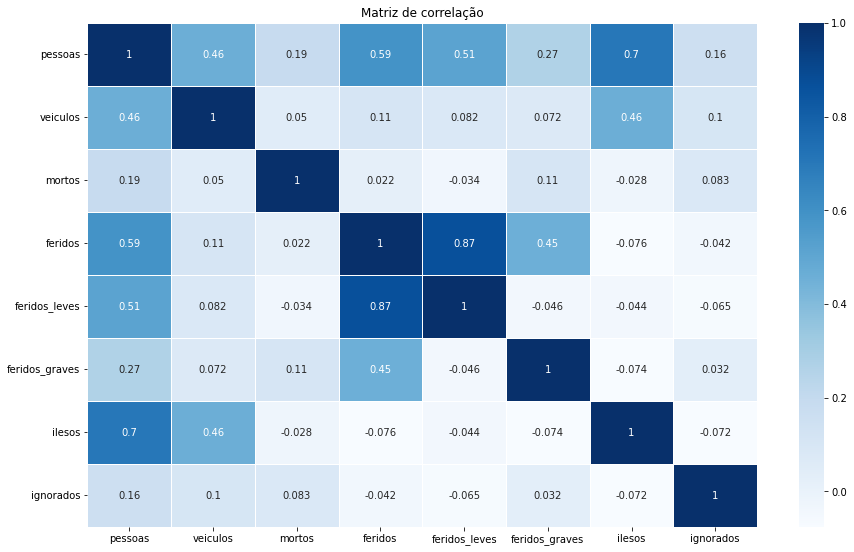

In [73]:
numericals = ['pessoas', 'veiculos', 'mortos', 'feridos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados']
ocorrencias_corr = ocorrencias[numericals].corr()
plt.figure(figsize=(15, 15/1.6180339))
sns.heatmap(ocorrencias_corr, annot=True, linewidths=.5, cmap='Blues')
plt.title('Matriz de correlação');

Com a matriz acima é possível observar que existe uma forte correlação entre "feridos" e "feridos_leves", indicando que a maioria dos feridos possuem ferimentos leves. Além de existir correlação forte entre "ilesos" e "pessoas", o que nos sugere que a maioria das pessoas envolvidas em acidentes saem sem danos físicos. Também observa-se uma correlação entre "feridos" e "pessoas", indicando que na maioria dos acidentes existem feridos.

<a id="estatisticas"/>

## 4. Estatísticas

In [49]:
numericals = ['pessoas', 'veiculos', 'mortos', 'feridos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados']
ocorrencias[numericals].describe()

,pessoas,veiculos,mortos,feridos,feridos_leves,feridos_graves,ilesos,ignorados
count,320753.000000,320753.000000,320753.000000,320753.000000,320753.000000,320753.000000,320753.000000,320753.000000
mean,2.338510,1.640948,0.076732,1.077368,0.826892,0.250476,1.048536,0.135874
std,1.835522,0.734762,0.329213,1.202247,1.072218,0.594930,1.420751,0.412977
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,3.000000,2.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,80.000000,23.000000,21.000000,66.000000,58.000000,28.000000,73.000000,16.000000


In [57]:
ocorrencias['pessoas'].mode()

0    2
dtype: int64

- Observa-se que as ocorrências envolvem, em média, 2.33 pessoas, 1.6 veículo, 1.07 pessoa ferida e 0.32 mortos. 
- A moda e mediana de pessoas envolvidas é de 2 pessoas, com o máximo chegando até 80 pessoas.
- O número máximo de mortes em um acidente foi de 21 pessoas, e o de feridos chegou a 66 pessoas.

<a id="norm"/>

## 5. Normalização

Optamos por normalizar os dados para o intervalo [0, 1] utilizando a classe `MinMaxScaler` do sci-kit learn.

In [37]:
numericals = ['pessoas', 'veiculos', 'mortos', 'feridos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X=ocorrencias[numericals])

ocorrencias_scaled = pd.DataFrame(scaled_data,columns=numericals)
ocorrencias_scaled.head()

,pessoas,veiculos,mortos,feridos,feridos_leves,feridos_graves,ilesos,ignorados
0,0.000000,0.0,0.0,0.015152,0.000000,0.035714,0.000000,0.0
1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.013699,0.0
2,0.012658,0.0,0.0,0.030303,0.034483,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.015152,0.000000,0.035714,0.000000,0.0
4,0.000000,0.0,0.0,0.015152,0.017241,0.000000,0.000000,0.0


In [38]:
ocorrencias_scaled.describe()

,pessoas,veiculos,mortos,feridos,feridos_leves,feridos_graves,ilesos,ignorados
count,320753.000000,320753.000000,320753.000000,320753.000000,320753.000000,320753.000000,320753.000000,320753.000000
mean,0.016943,0.029134,0.003654,0.016324,0.014257,0.008946,0.014364,0.008492
std,0.023234,0.033398,0.015677,0.018216,0.018487,0.021247,0.019462,0.025811
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.012658,0.045455,0.000000,0.015152,0.017241,0.000000,0.013699,0.000000
75%,0.025316,0.045455,0.000000,0.015152,0.017241,0.000000,0.013699,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Nota-se que agora todas as colunas numéricas tem como minímo e máximo 0 e 1, respectivamente.